In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import qda
import myfunc as mf

# Import the dataset
data = pd.read_csv('ESE6_CC.csv')

# Inspect the dataset

print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Thickness  40 non-null     int64
dtypes: int64(1)
memory usage: 448.0 bytes
None


,Thickness
0,100
1,109
2,103
3,109
4,96


Number of points n = 40
Mean = 84.75


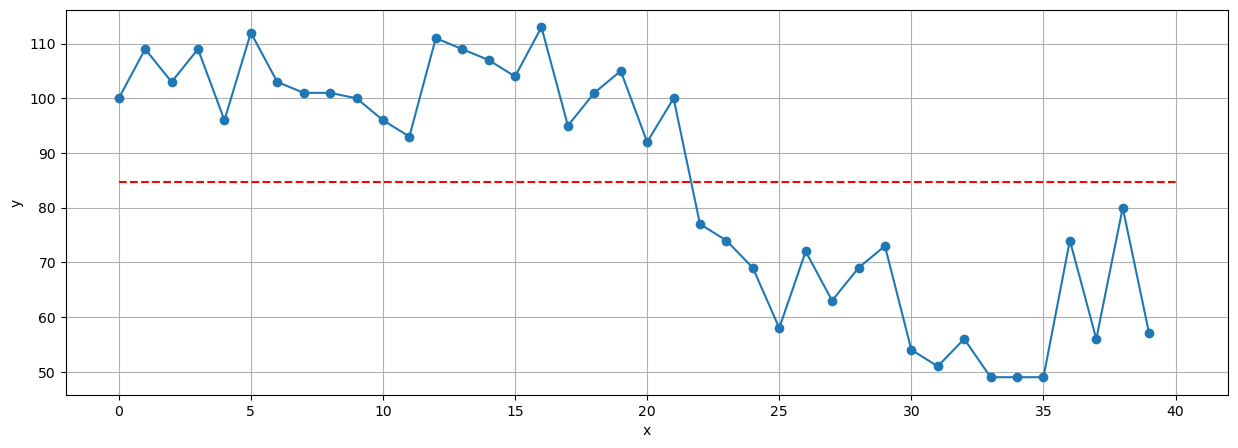

Runs test statistic = -6.085
Runs test p-value = 0.000
Reject H0: the data are not random
p-value of the Shapiro-Wilk test: 0.001


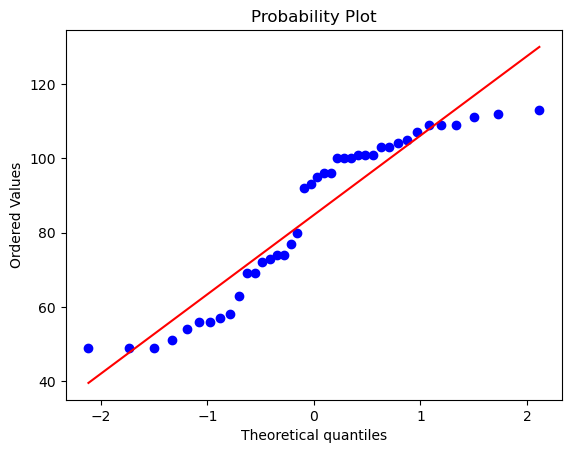

Reject H0: the data are not normal


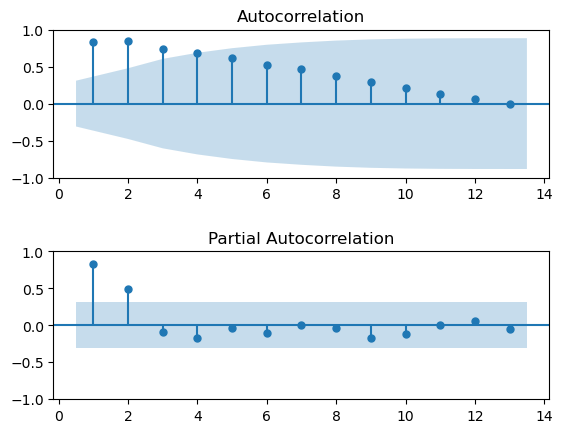

In [2]:
T=data['Thickness']
mf.single_ts_plot(T)
mf.runs(T)
mf.shapiroqq(T)
mf.acfpacf(T)

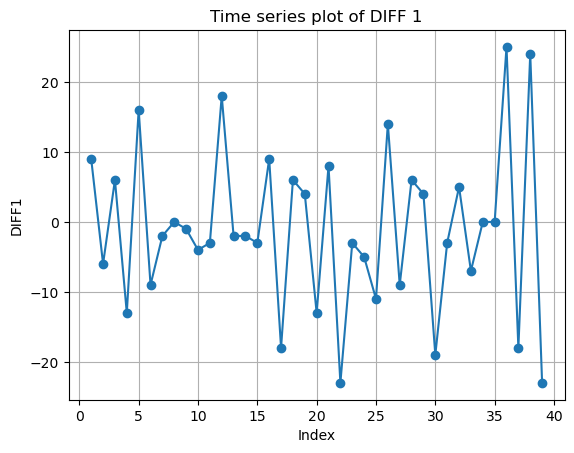

Runs test statistic = 1.834
Runs test p-value = 0.067
Accept H0: the data are random


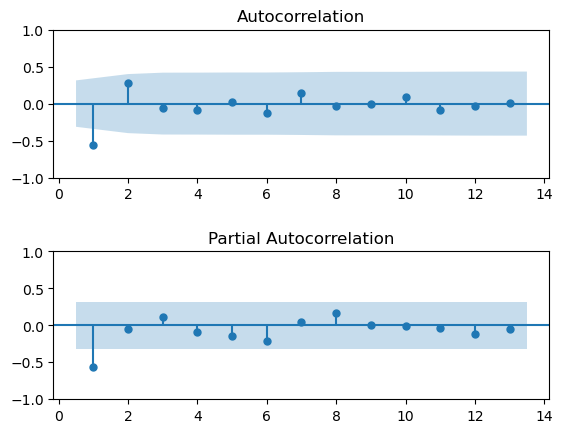

0     NaN
1     9.0
2    -6.0
3     6.0
4   -13.0
Name: diff_1, dtype: float64

In [4]:
data['lag1']=data['Thickness'].shift(1)
data['diff_1']=mf.diffprocess (data,'Thickness','lag1',1)
data['diff_1'].head()

In [34]:
#non è chiaro se c'è un termine AR o un termine MA, provare entrambi:
y = T #variabile y, quella su cui voglio fittare
p=1
d=1
q=0

model1 = qda.ARIMA(y, order=(p,d,q), add_constant = False) 
qda.ARIMAsummary(model1)
residuals1 = model1.resid[np.max((p,d,q)):] 
fits1 = model1.fittedvalues[np.max((p,d,q)):] 


---------------------
ARIMA MODEL RESULTS
---------------------
ARIMA model order: p=1, d=1, q=0

FINAL ESTIMATES OF PARAMETERS
-------------------------------
 Term    Coef  SE Coef  T-Value    P-Value
ar.L1 -0.5994   0.1339  -4.4759 7.6083e-06

RESIDUAL SUM OF SQUARES
-------------------------
  DF        SS      MS
38.0 3500.1613 92.1095

Ljung-Box Chi-Square Statistics
----------------------------------
 Lag  Chi-Square  P-Value
  12      5.4209   0.9424
  24     13.5992   0.9552
  36     23.3651   0.9484


Shapiro-Wilk test p-value on the residuals = 0.504
Runs test statistic = 0.491
Runs test p-value = 0.623
Accept H0: the data are random


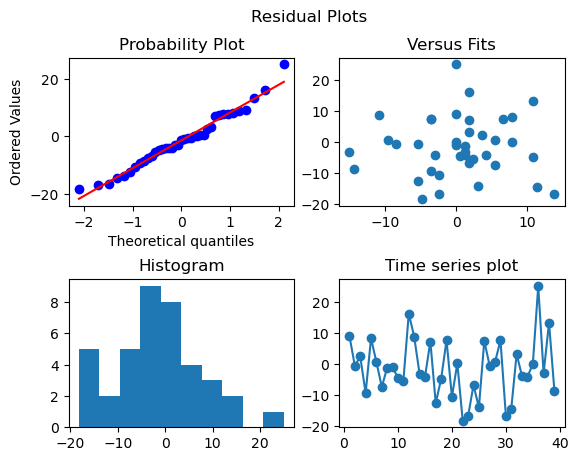

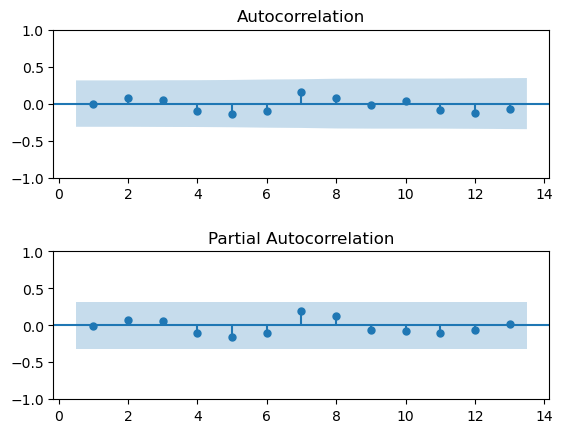

In [35]:
mf.shapirplusresplots(model1,1)
mf.runs(residuals1)
mf.acfpacf(residuals1)

In [36]:
y = T #variabile y, quella su cui voglio fittare
p=0
d=1
q=1

model2 = qda.ARIMA(y, order=(p,d,q), add_constant = False) 
qda.ARIMAsummary(model2)
residuals2 = model2.resid[np.max((p,d,q)):] 
fits2 = model2.fittedvalues[np.max((p,d,q)):] 

#ho 40 dati, che diventano 39 a causa della diff e 1 parametro
#quindi 39-1 gdl

---------------------
ARIMA MODEL RESULTS
---------------------
ARIMA model order: p=0, d=1, q=1

FINAL ESTIMATES OF PARAMETERS
-------------------------------
 Term    Coef  SE Coef  T-Value  P-Value
ma.L1 -0.4472    0.144  -3.1067   0.0019

RESIDUAL SUM OF SQUARES
-------------------------
  DF        SS       MS
38.0 3966.8072 104.3897

Ljung-Box Chi-Square Statistics
----------------------------------
 Lag  Chi-Square  P-Value
  12      7.7901   0.8013
  24     14.4500   0.9358
  36     37.3379   0.4074


Shapiro-Wilk test p-value on the residuals = 0.631
Runs test statistic = 1.834
Runs test p-value = 0.067
Accept H0: the data are random


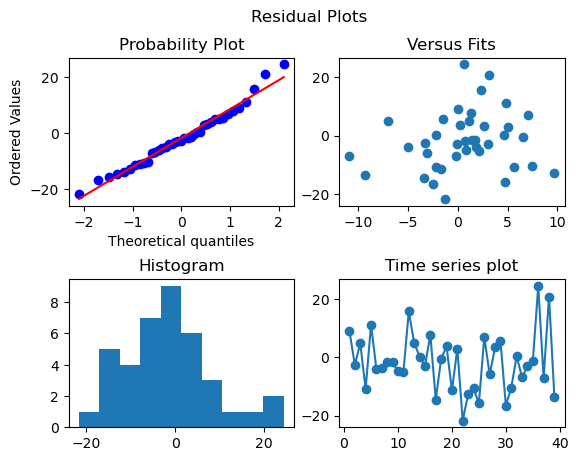

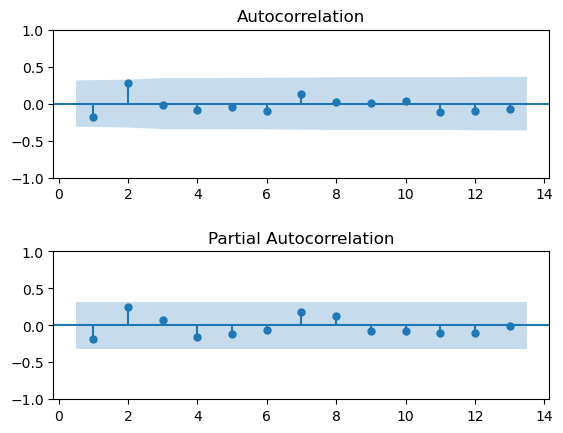

In [37]:
mf.shapirplusresplots(model2,1)
mf.runs(residuals2)
mf.acfpacf(residuals2)

il migliore è ARIMA(1,1,0) perchè p_value del parametro e MSE sono decisamente migliori.
nota che in realtà per dire che MSE di un modello è minore dell'altro bisognerebbe fare test d'ipotesi!

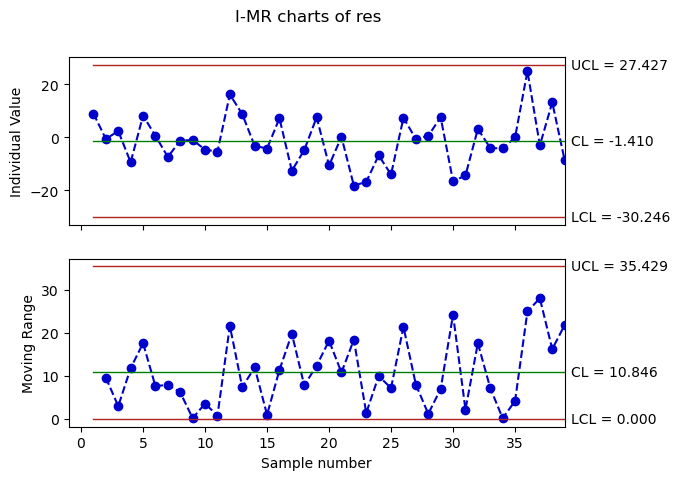

In [40]:
ARL0=100
alpha=1/100
k=stats.norm.ppf(1-alpha/2)
df_SCC = pd.DataFrame({'res': residuals1}) #lo chiamo direttamente df_SCC
df_SCC = qda.ControlCharts.IMR(df_SCC, 'res')


In [65]:
old_data=data['Thickness'].values
new_data=np.array([49,69,78,68,70,77,77,85,73,86])
#are they IC?
#we have to use our model
total_data=np.concatenate((old_data,new_data)) #con due (())

total = pd.DataFrame({'total_data': total_data})

#use directly the formula for the predictions:
total['fits']=(1-0.5994)*total['total_data'].shift(1)+0.5994*total['total_data'].shift(2) #ARIMA(1,1,0)
total['residuals']=total['total_data']-total['fits']#ci sono 2 nan al contrario dell'unico NaN in uscita
#da ARIMA package
#aggiungi residuo che manca:
total['residuals'].iloc[1]=residuals1.values[0]

c:\Users\alyuk\anaconda3\envs\qda\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [71]:
total['residuals'].tail(10)

40   -21.7862
41    15.2048
42    20.9880
43    -4.6054
44    -3.9940
45     8.1988
46     4.1958
47     8.0000
48    -7.2048
49     5.8072
Name: residuals, dtype: float64

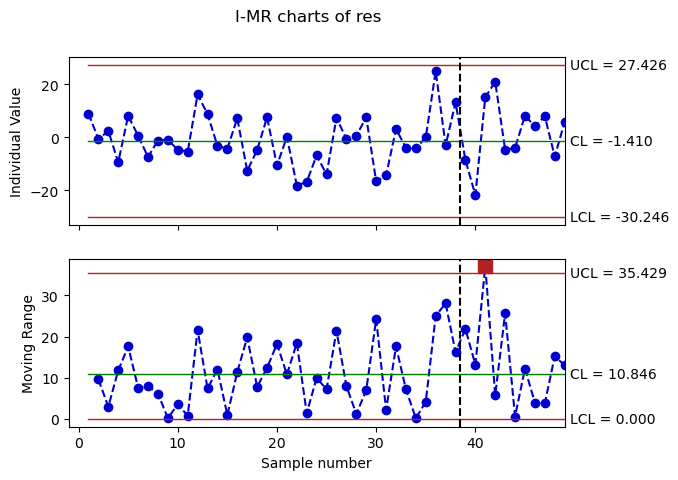

In [70]:
resi=total['residuals'].iloc[1:]#skippa il NaN
df_SCC = pd.DataFrame({'res': resi}) #lo chiamo direttamente df_SCC
df_SCC = qda.ControlCharts.IMR(df_SCC, 'res',subset_size=len(residuals1))